# Universidad del Valle de Guatemala
# (CC3092) Security Data Science
# Laboratorio 4 - Análisis de Malware

Miembros del equipo de trabajo:
- Yongbum Park (20117)
- Santiago Taracena Puga (20017)

## Introducción

El presente laboratorio de Security Data Science se centra en la aplicación de técnicas de análisis estático de malware y la implementación del algoritmo K-means para la clasificación de familias de malware. Con el aumento constante de amenazas cibernéticas, la identificación y clasificación efectiva de familias de malware son fundamentales para desarrollar respuestas y controles adecuados. En este contexto, se aborda la creación de un dataset a partir de ejemplos de malware proporcionados, donde se utilizará la herramienta pefile para realizar un análisis estático y extraer características relevantes.

La diversidad y complejidad del malware hacen necesario el empleo de técnicas de preprocesamiento de datos para garantizar la eficacia de los algoritmos de aprendizaje no supervisado. Por tanto, se explorarán y aplicarán diversas técnicas de preprocesamiento para asegurar la calidad y la manipulación adecuada de la información.

La implementación de dos algoritmos de partición para la creación de clústeres a partir del dataset permitirá determinar el número óptimo de clústeres mediante el método del codo y el coeficiente de Silhouette. Estos análisis empíricos se complementarán con la evaluación del índice de Jaccard para calcular la similitud entre las familias de malware, utilizando diferentes umbrales de similitud y características como strings y llamadas a funciones.

## Parte 1

### Creación del dataset

Para llevar a cabo la creación del dataset, se procedió con un análisis estático de los archivos de malware proporcionados utilizando la herramienta pefile. Esta herramienta permitió examinar en profundidad los archivos ejecutables y extraer información relevante, como el PE header, el nombre de las secciones y las llamadas a funciones realizadas.

Durante el análisis, se observó que los archivos de malware presentaban una variedad de características y comportamientos, lo que subraya la importancia de un enfoque detallado y exhaustivo en la extracción de características. Se identificaron diferentes familias de malware entre los ejemplos proporcionados, lo que respalda la necesidad de una clasificación precisa para desarrollar respuestas y controles adecuados.

Posteriormente, se procedió con la exploración y el preprocesamiento de los datos obtenidos del análisis estático. Se identificaron columnas que requerían técnicas de preprocesamiento para garantizar la calidad y la manipulación adecuada de la información. Entre las técnicas de preprocesamiento aplicadas se incluyeron la normalización de datos, el manejo de valores faltantes y la codificación de variables categóricas, con el fin de optimizar la preparación de los datos para su posterior análisis mediante algoritmos de aprendizaje no supervisado.

En conclusión, la etapa de creación del dataset proporcionó una base sólida para el análisis y la clasificación de familias de malware. El análisis estático de los archivos de malware, junto con el preprocesamiento adecuado de los datos, constituyen pasos fundamentales para avanzar hacia la implementación de algoritmos de clasificación y la determinación de similitudes entre las familias de malware identificadas.

La primera acción que resulta necesaria al momento de comenzar con la creación del dataset a utilizar durante el laboratorio consiste en el proceso de importar las librerías necesarias para abrir el malware en Python y analizarlo correctamente. Las librerías que necesitamos en este caso en particular son `os`, `hashlib`, `pefile` y `pandas` para guardar el dataset en el formato .csv que necesitamos.

In [562]:
# Librerías necesarias para armar el dataset.
import os
import hashlib
import pefile
import pandas as pd

Con las librerías necesarias disponibles para su utilización, necesitamos conseguir los hashes de cada archivo para poder utilizarlos con el objetivo de identificar cada malware del cual se están extrayendo características dentro del dataset. Para esto hemos desarrollado una función `get_file_hashes`, que obtiene los hashes utilizando la librería `hashlib` y los retorna para poder colocarlos como datos de columnas dentro de nuestro dataset.

In [563]:
# Función get_file_hashes, que obtiene los hashes de cada archivo de malware.
def get_file_hashes(file_path):

    # Apertura del archivo.
    with open(file_path, "rb") as file:

        # Obtención del contenido y los hashes del archivo.
        content = file.read()
        md5_hash = hashlib.md5(content).hexdigest()
        sha1_hash = hashlib.sha1(content).hexdigest()
        sha256_hash = hashlib.sha256(content).hexdigest()

    # Retorno de los hashes del archivo.
    return md5_hash, sha1_hash, sha256_hash

Con la función que extrae los hashes finalizada, es necesario crear otra función que nos brinde todas las características del malware que necesitamos utilizar con el objetivo de identificar los clústers necesarios. La función es bastante extensa, pero se encuentra propiamente comentada en cada una de sus secciones con el objetivo de facilitar su entendimiento. Utiliza principalmente la librería `pefile`, y la misma también se llama `extract_pe_features`, y finalmente tiene como objetivo, valga la redundancia, extraer las características de cada archivo de malware.

In [564]:
# Función extract_pe_features, que extrae las características necesarias del malware.
def extract_pe_features(file_path):

    # Lista de features que se retornarán.
    pe_features = []

    # Bloque try-catch que abre y accede al malware.
    try:

        # Primeras catacterísticas a extraer.
        pe = pefile.PE(file_path)
        pe_features.append(len(pe.sections))  # Número de secciones.
        pe_features.append(pe.FILE_HEADER.Machine)  # Arquitectura de la máquina.
        pe_features.append(pe.FILE_HEADER.Characteristics)  # Características del archivo.
        pe_features.append(pe.OPTIONAL_HEADER.SizeOfCode)  # Tamaño del código.
        pe_features.append(pe.OPTIONAL_HEADER.SizeOfInitializedData)  # Tamaño de datos inicializados.
        pe_features.append(pe.OPTIONAL_HEADER.SizeOfUninitializedData)  # Tamaño de datos no inicializados.
        pe_features.append(pe.OPTIONAL_HEADER.AddressOfEntryPoint)  # Dirección del punto de entrada.
        pe_features.append(pe.OPTIONAL_HEADER.ImageBase)  # Base de la imagen.
        pe_features.append(pe.OPTIONAL_HEADER.MajorSubsystemVersion)  # Versión del subsistema principal.
        pe_features.append(pe.OPTIONAL_HEADER.Subsystem)  # Subsistema.
        pe_features.append(pe.OPTIONAL_HEADER.DllCharacteristics)  # Características de DLL.
        
        # Checksum del archivo.
        pe_features.append(pe.OPTIONAL_HEADER.CheckSum)

        # Importaciones de funciones del archivo.
        imports = []
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                imports.append(imp.name.decode("utf-8", "ignore"))
        pe_features.append(imports)

        # Exportaciones de funciones del archivo.
        exports = []
        if (hasattr(pe, "DIRECTORY_ENTRY_EXPORT")):
            for exp in pe.DIRECTORY_ENTRY_EXPORT.symbols:
                exports.append(exp.name.decode("utf-8", "ignore"))
        pe_features.append(exports)

        # Tiempo de compilación del archivo.
        pe_features.append(pe.FILE_HEADER.TimeDateStamp)

        # Firma digital del archivo.
        pe_features.append("Signed" if (hasattr(pe, "DIRECTORY_ENTRY_CERT")) else "Unsigned")

        # Versiones de recursos del archivo.
        if (hasattr(pe, "VS_VERSIONINFO")):
            pe_features.append(pe.VS_VERSIONINFO.ProductVersion)
            pe_features.append(pe.VS_VERSIONINFO.FileVersion)
        else:
            pe_features.append(None)
            pe_features.append(None)

        # Entropía del archivo.
        section_entropies = [section.get_entropy() for section in pe.sections]
        pe_features.append(section_entropies)

        # Secciones ejecutables del archivo.
        executable_sections = [section.IMAGE_SCN_MEM_EXECUTE for section in pe.sections]
        pe_features.append(executable_sections)

        # Número de secciones ejecutables del archivo.
        executable_sections_length = sum(section.IMAGE_SCN_MEM_EXECUTE for section in pe.sections)
        pe_features.append(executable_sections_length)

        # TLS (Thread Local Storage) del archivo.
        pe_features.append(pe.OPTIONAL_HEADER.DATA_DIRECTORY[9].VirtualAddress)
        pe_features.append(pe.OPTIONAL_HEADER.DATA_DIRECTORY[9].Size)

        # Dimensiones del Entry Resource del archivo.
        if (hasattr(pe, "DIRECTORY_ENTRY_RESOURCE")):
            pe_features.append(len(pe.DIRECTORY_ENTRY_RESOURCE.entries))
            resource_size = sum(resource.directory.SizeOfData for resource in pe.DIRECTORY_ENTRY_RESOURCE.entries)
            pe_features.append(resource_size)
        else:
            pe_features.extend([0, 0])

    # Manejo de cualquier error manipulando el archivo.
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

    # Retorno de las features halladas.
    return pe_features

Con nuestra función de extracción de características de los archivos de malware proporcionados efectivamente completada, nos queda utilizarla junto con la función que fue creada para la obtención de hashes con el objetivo de crear el dataset. Debemos indicar la ruta del folder con el malware y la ruta del archivo .csv de salida con las características que necesitamos utilizar para el análisis.

In [565]:
# Rutas de entrada y de salida.
malware_folder = "./MALWR/MALWR"
output_csv = "./data/malware-dataset.csv"

Con estas rutas configuradas correctamente, nos hace falta una lista con toda la data a almacenar con el objetivo de finalmente ser almacenada en el archivo .csv que también configuramos.

In [566]:
# Lista con los datos a guardar.
data = []

Todo está correctamente configurado, y ahora lo único que hace falta es codificar el proceso de iterar en la carpeta con el malware y extraer todas sus características, para finalmente guardarlas en la lista `data` que instanciamos anteriormente.

In [567]:
# Ciclo que itera el folder de malware y guarda las características adquiridas.
for file_name in os.listdir(malware_folder):
    file_path = os.path.join(malware_folder, file_name)
    md5_hash, sha1_hash, sha256_hash = get_file_hashes(file_path)
    pe_features = extract_pe_features(file_path)
    data.append([file_name, md5_hash, sha1_hash, sha256_hash] + pe_features)

Error processing ./MALWR/MALWR\.DS_Store: 'DOS Header magic not found.'
Error processing ./MALWR/MALWR\1F2EB7B090018D975E6D9B40868C94CA: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\33DE5067A433A6EC5C328067DC18EC37: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\65018CD542145A3792BA09985734C12A: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\650A6FCA433EE243391E4B4C11F09438: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\6FAA4740F99408D4D2DDDD0B09BBDEFD: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\785003A405BC7A4EBCBB21DDB757BF3F: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\8442AE37B91F279A9F06DE4C60B286A3: 'ResourceDirData' object has no attribute 'SizeOfData'
Error processing ./MALWR/MALWR\99A39866A657A10949FCB6D634BB30D5: 'ResourceDirData' objec

Finalmente, estamos listos para escribir el archivo .csv con las características encontradas por parte de cada uno de los archivos. Debemos configurar las columnas, el dataframe, y finalmente llamar a la función `to_csv` para pasar el dataframe al formato .csv que necesitamos utilizar.

In [568]:
# Columnas del dataset.
columns = [
  "file_name", "md5", "sha1", "sha256", "num_sections", "machine", "characteristics",
  "size_of_code", "size_of_initialized_data", "size_of_uninitialized_data", "address_of_entry_point",
  "image_base", "major_subsystem_version", "subsystem", "dll_characteristics", "checksum",
  "imports", "exports", "time_date_stamp", "digital_signature", "product_version",
  "file_version", "section_entropies", "executable_sections", "executable_sections_length",
  "tls_virtual_address", "tls_size", "resources_section_entries", "resources_section_size",
]

# Instancia del dataframe con la data recolectada.
df = pd.DataFrame(data, columns=columns)

# Guardado del dataframe en formato .csv.
df.to_csv(output_csv, index=False)

### Exploración y pre procesamiento de datos

Una vez completado el análisis estático de los archivos de malware y la creación del dataset inicial, se procedió con la etapa de exploración y preprocesamiento de los datos. Esta fase es crucial para garantizar la calidad y la adecuación de los datos para su posterior análisis mediante algoritmos de aprendizaje no supervisado.

Durante la exploración de los datos, se realizaron diversas acciones para comprender mejor la naturaleza y la distribución de las características presentes en el dataset. Se examinaron estadísticas descriptivas, como medias, desviaciones estándar y rangos, para identificar posibles anomalías o patrones significativos en los datos. Además, se visualizaron gráficos y diagramas de dispersión para explorar relaciones entre variables y detectar posibles correlaciones o agrupamientos.

Tras la exploración inicial, se procedió con el preprocesamiento de los datos para abordar posibles problemas como la presencia de valores faltantes, la normalización de variables numéricas y la codificación de variables categóricas. Se aplicaron técnicas de imputación para manejar valores faltantes, utilizando estrategias como la imputación por la media o la moda de la columna correspondiente.

Para garantizar que las variables numéricas tuvieran un rango similar y no fueran dominantes en el proceso de agrupamiento, se realizó la normalización de datos mediante técnicas como la estandarización o la escala min-max. Esto permitió que todas las características contribuyeran de manera equitativa al proceso de clasificación.

Además, se procedió con la codificación de variables categóricas utilizando técnicas como el label encoding, que convierte variables categóricas en vectores binarios, facilitando su inclusión en los algoritmos de aprendizaje automático.

Lo primero que debemos realizar con el objetivo de preprocesar y explorar los datos con los que terminamos luego de adquirir los mismos es importar la librería `pandas` para poder abrir el archivo que generamos y poder interactuar con el mismo.

In [569]:
# Librerías necesarias para desarrollar el laboratorio.
import pandas as pd

Con la librería importada, podemos proceder a leer el archivo y almacenarlo en un DataFrame de `pandas` utilizando la función `read_csv`, que lee un archivo .csv dada una ruta al mismo y retorna un DataFrame que podemos utilizar para analizar los datos y entrenar a los modelos que estaremos instanciando en el futuro.

In [570]:
# Lectura de datos con pandas.
data = pd.read_csv("./data/malware-dataset.csv")

Con la data obtenida cargada en el presente notebook, podemos observar las columnas y dar un pequeño vistazo utilizando la función `head` que viene con la clase DataFrame que estamos utilizando. Esta función nos permite observar los primeros cinco registros del dataset, por defecto.

In [571]:
# Primeros cinco registros del dataset.
data.head()

,file_name,md5,sha1,sha256,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,product_version,file_version,section_entropies,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size
0,.DS_Store,7696dfa1913df71b116455221f201de0,0a0d99fcfec81d7d9c7f7a7df0ba60d196a7f141,0764d8ccf0a4e03d254b40f65d7939595642598dd41fcf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1F2EB7B090018D975E6D9B40868C94CA,ce91225d493753ef351f132b84addb58,997982756092ac603570536cc5334a542647ab45,0a76f1439cc52fed9e9627f82686c6daedefcf191952ae...,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.263576e+09,Unsigned,NaN,NaN,"[0.0, 7.565065380188014, 2.5736900127135667]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
2,33DE5067A433A6EC5C328067DC18EC37,c1d952dc830080046723d63f70e790e9,992e9e924ab5fb4e85ba00da37b8ae6414a7289c,2512c61f77b21ec2847379453b3035f6e23ab77d8ab092...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.533359674945775, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
3,65018CD542145A3792BA09985734C12A,da035a6ba07e51b939ffdea2d2e9381e,cd4725b74baebec6faaacb0fdd81cbd44830162b,4086f0a4f2a15c4e5896a158950e13c9350b4d9e850a0f...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.53185495424105, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
4,650A6FCA433EE243391E4B4C11F09438,768f27f004110971bb096c8b96b7c52e,678591ab1840c8f0f618c8e59e22aec68fba8573,08c41e549dd5d125860b8aa2b9e0c8b736e068a177cf8a...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.242321e+09,Unsigned,NaN,NaN,"[0.0, 7.536876934949231, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN


Las columnas "file_name", "md5", "sha1" y "sha256" fueron colocadas con el objetivo de representar cada entrada por medio de la información básica del nombre del ejecutable y sus hashes, pero teniendo como objetivo obtener clústers que nos permitan observar cuántos tipos de malware hay, podemos deshacernos de estas columnas para manejar únicamente columnas que no sean tan específicas como estos datos obtenidos por parte de cada malware presente en la carpeta brindada.

In [572]:
# Eliminación de las columnas mencionadas.
data = data.drop(["file_name", "md5", "sha1", "sha256"], axis=1)

Con estas columnas eliminadas, podemos observar cómo estas ya no se encuentran disponibles en el dataset que estamos manejando. Nos quedamos con cuatro columnas menos las cuales debemos observar y analizar para la ingeniería de características a utilizar.

In [573]:
# Primeros cinco registros sin las columnas mencionadas.
data.head()

,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,product_version,file_version,section_entropies,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.263576e+09,Unsigned,NaN,NaN,"[0.0, 7.565065380188014, 2.5736900127135667]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
2,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.533359674945775, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
3,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.53185495424105, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
4,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.242321e+09,Unsigned,NaN,NaN,"[0.0, 7.536876934949231, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN


Podemos seguir obteniendo información para observar las columnas que nos quedaron. La función `info` es perfecta para esta tarea, ya que nos retorna un DataFrame con el nombre de cada columna y el tipo de dato que la misma nos presenta.

In [574]:
# Información de las columnas del dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_sections                40 non-null     float64
 1   machine                     40 non-null     float64
 2   characteristics             40 non-null     float64
 3   size_of_code                40 non-null     float64
 4   size_of_initialized_data    40 non-null     float64
 5   size_of_uninitialized_data  40 non-null     float64
 6   address_of_entry_point      40 non-null     float64
 7   image_base                  40 non-null     float64
 8   major_subsystem_version     40 non-null     float64
 9   subsystem                   40 non-null     float64
 10  dll_characteristics         40 non-null     float64
 11  checksum                    40 non-null     float64
 12  imports                     40 non-null     object 
 13  exports                     40 non-nu

La gran mayoría de columnas que se encuentran presentes en el dataset son columnas numéricas decimales, lo cual es una muy buena noticia, ya que estas son las columnas que buscamos con el objetivo de entrenar a un modelo de inteligencia artificial no supervisado como el que vamos a utilizar. Sin embargo, hay algunas columnas categóricas que tenemos qué analizar y preprocesar. Para observar cuáles son, podemos seleccionar las columnas categóricas con la función `select_dtypes`, y posteriormente retornar las columnas de este dataset filtrado.

In [575]:
# Retorno de las columnas categóricas del dataset.
data.select_dtypes(include="object").columns

Index(['imports', 'exports', 'digital_signature', 'section_entropies',
       'executable_sections'],
      dtype='object')

Sabiendo cuáles son estas columnas, podemos empezar a observar qué contienen y cómo podemos preprocesarlas correctamente. La primera columna que aparece es la del listado de APIs importadas por parte del ejecutable, por lo que podemos observar sus valores únicos utilizando la función `unique` y también podemos graficar la distribución de estas APIs utilizando la función `hist`.

In [576]:
# Valores únicos en la columna "imports".
data["imports"].unique()

array([nan,
       "['LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', 'atol', 'LoadStringA', 'send']",
       "['LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', 'atol', 'SHChangeNotify', 'LoadStringA', 'closesocket']",
       "['RegSaveKeyA', 'BitBlt', 'LoadLibraryA', 'GetProcAddress', 'VirtualProtect', 'free', 'Netbios', 'atoi', 'GetDC', 'WSAGetLastError']",
       "['RegSaveKeyA', 'BitBlt', 'LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', '_iob', 'Netbios', 'EnumProcessModules', 'GetDC', 'send']",
       "['CreateFileA', 'LocalAlloc', 'Sleep', 'CreateThread', 'CreateMutexA', 'CopyFileW', 'GetFileSize', 'CreateProcessA', 'GetEnvironmentVariableW', 'GetShortPathNameW', 'GetStartupInfoA', 'GetModuleHandleA', 'ReadFile', 'LocalFree', 'GetLastError', 'GetModuleFileNameW', 'CloseHandle', 'SendMessageA', 'FindWindowExA', 'RegQueryValueExA', 'RegCloseKey', 'RegSetValueExW', 'RegOpenKeyExA', 'SHGetSpecialFolderPathW', 'ShellExecuteW', '_co

<AxesSubplot:>

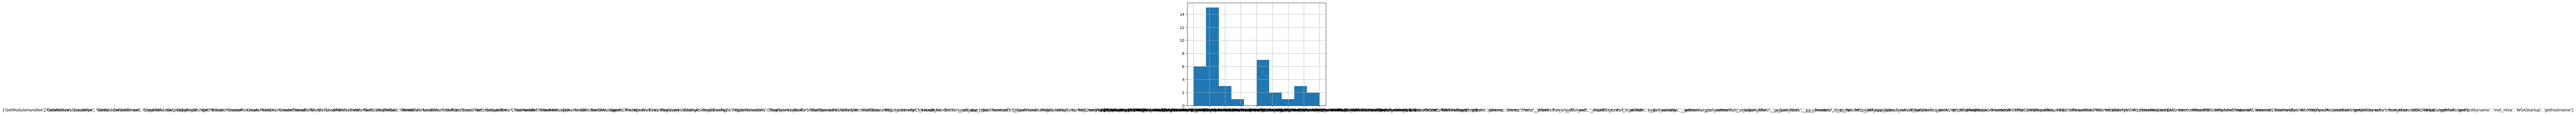

In [577]:
# Histograma de los valores de la columna "imports".
data["imports"].hist()

La distribución de esta columna es bastante desbalanceada, pero por lo demás la información se encuentra bastante bien. Sería bastante útil eliminar el "nan" por algo como una lista vacía, lo cual es sumamente fácil de hacer debido a la existencia de la función `fillna`.

In [578]:
# Proceso de remover los "nan" con listas vacías.
data["imports"] = data["imports"].fillna("[]")
data["imports"].unique()

array(['[]',
       "['LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', 'atol', 'LoadStringA', 'send']",
       "['LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', 'atol', 'SHChangeNotify', 'LoadStringA', 'closesocket']",
       "['RegSaveKeyA', 'BitBlt', 'LoadLibraryA', 'GetProcAddress', 'VirtualProtect', 'free', 'Netbios', 'atoi', 'GetDC', 'WSAGetLastError']",
       "['RegSaveKeyA', 'BitBlt', 'LoadLibraryA', 'ExitProcess', 'GetProcAddress', 'VirtualProtect', '_iob', 'Netbios', 'EnumProcessModules', 'GetDC', 'send']",
       "['CreateFileA', 'LocalAlloc', 'Sleep', 'CreateThread', 'CreateMutexA', 'CopyFileW', 'GetFileSize', 'CreateProcessA', 'GetEnvironmentVariableW', 'GetShortPathNameW', 'GetStartupInfoA', 'GetModuleHandleA', 'ReadFile', 'LocalFree', 'GetLastError', 'GetModuleFileNameW', 'CloseHandle', 'SendMessageA', 'FindWindowExA', 'RegQueryValueExA', 'RegCloseKey', 'RegSetValueExW', 'RegOpenKeyExA', 'SHGetSpecialFolderPathW', 'ShellExecuteW', '_c

Procedemos a realizar el mismo procedimiento de visualización y preprocesamiento de la data con la siguiente columna categórica que se nos presenta, la cual es "exports". Los pasos siguen siendo los mismos, es decir, ver valores únicos, limpiar los "nan" y graficar la distribución de la columna.

In [579]:
# Valores únicos de la columna.
data["exports"].unique()

array([nan, '[]',
       "['RundllInstall', 'RundllUninstall', 'ServiceInstall', 'ServiceMain', 'UnServiceInstall']"],
      dtype=object)

In [580]:
# Rellenado de las filas con "nan".
data["exports"] = data["exports"].fillna("[]")

<AxesSubplot:>

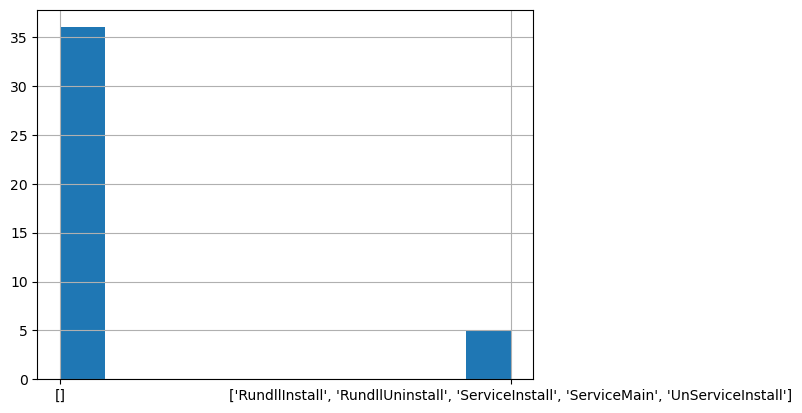

In [581]:
# Histograma de los valores de la columna.
data["exports"].hist()

La columna "exports" resultó bastante más sencilla de clasificar, preprocesar y visualizar a comparación de la columna de APIs importadas por cada malware analizado. La columna que sigue es "digital_signature", y podemos observar las mismas características con el mismo procedimiento.

In [582]:
# Valores únicos de la columna.
data["digital_signature"].unique()

array([nan, 'Unsigned'], dtype=object)

<AxesSubplot:>

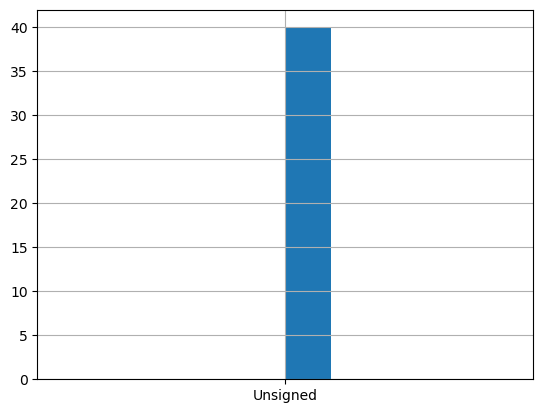

In [583]:
# Histograma de la columna.
data["digital_signature"].hist()

In [584]:
# Rellenado de valores "nan", es decir, el único unsigned.
data["digital_signature"].fillna("Unsigned")

0     Unsigned
1     Unsigned
2     Unsigned
3     Unsigned
4     Unsigned
5     Unsigned
6     Unsigned
7     Unsigned
8     Unsigned
9     Unsigned
10    Unsigned
11    Unsigned
12    Unsigned
13    Unsigned
14    Unsigned
15    Unsigned
16    Unsigned
17    Unsigned
18    Unsigned
19    Unsigned
20    Unsigned
21    Unsigned
22    Unsigned
23    Unsigned
24    Unsigned
25    Unsigned
26    Unsigned
27    Unsigned
28    Unsigned
29    Unsigned
30    Unsigned
31    Unsigned
32    Unsigned
33    Unsigned
34    Unsigned
35    Unsigned
36    Unsigned
37    Unsigned
38    Unsigned
39    Unsigned
40    Unsigned
Name: digital_signature, dtype: object

La columna presenta todo el malware en estado Unsigned, es decir, sin firma digital. Únicamente fue necesario cambiar un valor "nan" a "Unsigned", ya que el malware fue analizado individualmente y, efectivamente, presentaba un estado de "Unsigned". La siguiente columna a observar es "section_entropies" la cual resulta muy interesante.

In [585]:
data["section_entropies"].unique()

array([nan, '[0.0, 7.565065380188014, 2.5736900127135667]',
       '[0.0, 7.533359674945775, 2.9876524007111227]',
       '[0.0, 7.53185495424105, 2.9876524007111227]',
       '[0.0, 7.536876934949231, 2.9876524007111227]',
       '[0.0, 7.53896782380375, 2.9876524007111227]',
       '[0.0, 7.544000450805727, 2.9876524007111227]',
       '[0.0, 7.5806919158085355, 2.5775962627135667]',
       '[0.0, 7.523040324845204, 2.9876524007111227]',
       '[0.0, 7.532823953038207, 2.9876524007111227]',
       '[0.0, 7.896621228967558, 2.9572088080925063]',
       '[0.0, 7.8966623740996855, 2.9591619330925063]',
       '[0.0, 7.574681778291654, 2.5736900127135667]',
       '[0.0, 7.89958322760233, 3.785294290138867]',
       '[0.0, 7.5337536100876035, 2.9876524007111227]',
       '[6.241011178413984, 4.15134652699513, 4.053479681205818]',
       '[0.0, 7.574147822090668, 2.5775962627135667]',
       '[0.0, 7.578296200105048, 2.5736900127135667]',
       '[0.0, 7.535127597099006, 2.98765240071112

Podemos observar cómo cada entrada es un array con tres valores. Estos valores son la entropía de cada una de las secciones que se encuentran presentes en el malware. Sin embargo, este formato de la data no resulta nada útil por cómo es actualmente. Tenemos qué reemplazar el "nan" por un array con tres valores y después sacar los tres valores de cada entrada y colocarlos cada uno en su respectiva columna.

In [586]:
# Relleno de los valores "nan" con una lista con tres valores en cero.
data["section_entropies"] = data["section_entropies"].fillna("[0.0, 0.0, 0.0]")

In [587]:
# Librería que nos permite evaluar cada lista de la columna.
from ast import literal_eval

In [588]:
# Cambio de string a lista en la columna.
data["section_entropies"] = data["section_entropies"].apply(lambda entry: literal_eval(entry))
data["section_entropies"]

0                                       [0.0, 0.0, 0.0]
1          [0.0, 7.565065380188014, 2.5736900127135667]
2          [0.0, 7.533359674945775, 2.9876524007111227]
3           [0.0, 7.53185495424105, 2.9876524007111227]
4          [0.0, 7.536876934949231, 2.9876524007111227]
5           [0.0, 7.53896782380375, 2.9876524007111227]
6          [0.0, 7.544000450805727, 2.9876524007111227]
7         [0.0, 7.5806919158085355, 2.5775962627135667]
8          [0.0, 7.523040324845204, 2.9876524007111227]
9          [0.0, 7.532823953038207, 2.9876524007111227]
10         [0.0, 7.896621228967558, 2.9572088080925063]
11        [0.0, 7.8966623740996855, 2.9591619330925063]
12         [0.0, 7.574681778291654, 2.5736900127135667]
13           [0.0, 7.89958322760233, 3.785294290138867]
14        [0.0, 7.5337536100876035, 2.9876524007111227]
15    [6.241011178413984, 4.15134652699513, 4.053479...
16         [0.0, 7.574147822090668, 2.5775962627135667]
17         [0.0, 7.578296200105048, 2.5736900127

In [589]:
# Agregación de las tres nuevas columnas con cada entropía.
data[["first_section_entropy", "second_section_entropy", "third_section_entropy"]] = pd.DataFrame(data["section_entropies"].tolist())
data = data.drop("section_entropies", axis=1)

In [590]:
# Retorno del dataset con las tres nuevas columnas agregadas.
data[["first_section_entropy", "second_section_entropy", "third_section_entropy"]]

,first_section_entropy,second_section_entropy,third_section_entropy
0,0.000000,0.000000,0.000000
1,0.000000,7.565065,2.573690
2,0.000000,7.533360,2.987652
3,0.000000,7.531855,2.987652
4,0.000000,7.536877,2.987652
5,0.000000,7.538968,2.987652
6,0.000000,7.544000,2.987652
7,0.000000,7.580692,2.577596
8,0.000000,7.523040,2.987652
9,0.000000,7.532824,2.987652


Con este procedimiento obtenemos como resultado tres columnas que se vuelven increíblemente valiosas en lugar de una columna con un array que era prácticamente inutilizable. Finalmente podemos proceder con la columna "executable_sections" y tratarla de la misma forma que se trataron las anteriores.

In [591]:
# Valores únicos de la columna.
data["executable_sections"].unique()

array([nan, '[True, True, False]', '[True, False, False]'], dtype=object)

<AxesSubplot:>

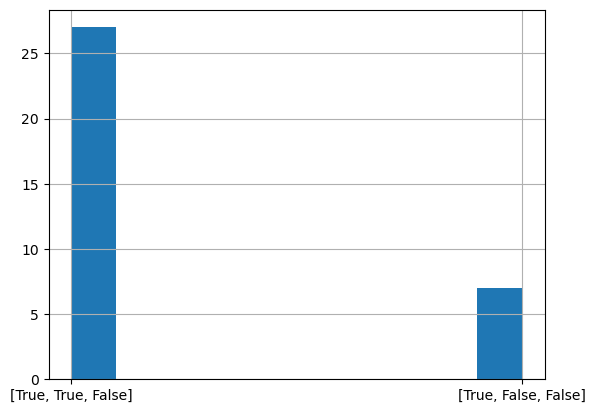

In [592]:
# Histograma de la columna.
data["executable_sections"].hist()

Con cómo hemos podido observar cada una de las columnas, ahora podemos obtener como conclusión las columnas que se necesitan preprocesar. Las que se necesitan codificar de primero son las columnas de tipo "object", las cuales son las categóricas.

In [593]:
# Columnas categóricas del dataset.
list(data.select_dtypes(include="object").columns)

['imports', 'exports', 'digital_signature', 'executable_sections']

In [594]:
# dd = data.copy()
# dd.info()

In [595]:
len(dd['imports'])

41

In [596]:
len(dd['exports'])

41

Este es el listado de columnas categóricas a codificar. En este caso en específico, el plan es utilizar `LabelEncoder` con el objetivo de pasar de datos categóricos a datos numéricos fáciles de utilizar y comprender por parte de un modelo de aprendizaje no supervisado como el que estamos utilizando.

In [597]:
# Clase LabelEncoder que nos permitirá codificar.
from sklearn.preprocessing import LabelEncoder

# Columnas a codificar del dataset.
columns_to_encode = list(data.select_dtypes(include="object").columns)

# Ciclo que codifica cada columna.
for column in columns_to_encode:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])

# Retorno de las columnas codificadas.
data[columns_to_encode].head()

,imports,exports,digital_signature,executable_sections
0,9,1,1,2
1,3,1,0,1
2,4,1,0,1
3,4,1,0,1
4,4,1,0,1


Finalmente nuestras columnas están en orden. Ahora podemos a proceder a dar una checada rápida con el objetivo de observar valores nulos y anomalías que no nos sirvan al momento de entrenar los modelos.

In [598]:
# Sumatoria de valores nulos.
data.isnull().sum()

num_sections                   1
machine                        1
characteristics                1
size_of_code                   1
size_of_initialized_data       1
size_of_uninitialized_data     1
address_of_entry_point         1
image_base                     1
major_subsystem_version        1
subsystem                      1
dll_characteristics            1
checksum                       1
imports                        0
exports                        0
time_date_stamp                1
digital_signature              0
product_version               41
file_version                  41
executable_sections            0
executable_sections_length     7
tls_virtual_address            7
tls_size                       7
resources_section_entries      7
resources_section_size        28
first_section_entropy          0
second_section_entropy         0
third_section_entropy          0
dtype: int64

Los valores nulos en las columnas "product_version" y "file_version" son la totalidad nulos, por lo que consideramos que lo mejor sería deshacernos completamente de estas dos columnas, lo cual es una acción que podemos realizar con la función `drop` del dataset.

In [599]:
# Eliminación y retorno del dataset.
data = data.drop(["product_version", "file_version"], axis=1)
data.head()

,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size,first_section_entropy,second_section_entropy,third_section_entropy
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,NaN,1,2,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000
1,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,3,1,1.263576e+09,0,1,2.0,0.0,0.0,1.0,NaN,0.0,7.565065,2.573690
2,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,NaN,0.0,7.533360,2.987652
3,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,NaN,0.0,7.531855,2.987652
4,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.242321e+09,0,1,2.0,0.0,0.0,1.0,NaN,0.0,7.536877,2.987652


Otra columna que nos gustaría observar es "num_sections", por lo que se observarán los valores nulos ubicados en la misma con el objetivo de analizar su comportamiento y poder reemplazar estas celdas sin información valiosa por algo que sí lo sea.

In [600]:
# Valores únicos en la columna.
data["num_sections"].unique()

array([nan,  3.,  4.])

Los valores nulos serán rellenados con un cero. Esto lo podemos aplicar con la función `fillna`, indicando el valor con el que queremos rellenar todos los valores nulos que se encuentren en el dataset.

In [601]:
# Relleno de valores nulos.
data.fillna(0, inplace=True)
data.head()

,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size,first_section_entropy,second_section_entropy,third_section_entropy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1,0.000000e+00,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,3,1,1.263576e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.565065,2.573690
2,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.533360,2.987652
3,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.531855,2.987652
4,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.242321e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.536877,2.987652


In [602]:
# Nueva información del dataset limpio.
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_sections                41 non-null     float64
 1   machine                     41 non-null     float64
 2   characteristics             41 non-null     float64
 3   size_of_code                41 non-null     float64
 4   size_of_initialized_data    41 non-null     float64
 5   size_of_uninitialized_data  41 non-null     float64
 6   address_of_entry_point      41 non-null     float64
 7   image_base                  41 non-null     float64
 8   major_subsystem_version     41 non-null     float64
 9   subsystem                   41 non-null     float64
 10  dll_characteristics         41 non-null     float64
 11  checksum                    41 non-null     float64
 12  imports                     41 non-null     int32  
 13  exports                     41 non-nu

Podemos observar cómo todas las columnas se encuentran limpias y en formato numérico, que finalmente podremos utilizar con el objetivo de entrenar el modelo. Podemos verificar que las columnas sean del tipo que necesitamos con la función `select_dtypes`, para observar qué columnas son de cada tipo.

In [603]:
# Columnas de tipo float64.
data.select_dtypes(include="float64").columns

Index(['num_sections', 'machine', 'characteristics', 'size_of_code',
       'size_of_initialized_data', 'size_of_uninitialized_data',
       'address_of_entry_point', 'image_base', 'major_subsystem_version',
       'subsystem', 'dll_characteristics', 'checksum', 'time_date_stamp',
       'executable_sections_length', 'tls_virtual_address', 'tls_size',
       'resources_section_entries', 'resources_section_size',
       'first_section_entropy', 'second_section_entropy',
       'third_section_entropy'],
      dtype='object')

In [604]:
# Columnas de tipo int32.
data.select_dtypes(include="int32").columns

Index(['imports', 'exports', 'digital_signature', 'executable_sections'], dtype='object')

In [605]:
# Columnas de tipo object (no debería haber ninguna).
data.select_dtypes(include="object").columns

Index([], dtype='object')

In [606]:
from sklearn.cluster import KMeans

# Suponiendo que "data" es tu DataFrame limpio

# Especifica el número de clusters que deseas
num_clusters = 3

# Inicializa el modelo K-Means
kmeans_model = KMeans(n_clusters=num_clusters)

# Entrena el modelo con tus datos
kmeans_model.fit(data)

# Obtiene las etiquetas de cluster asignadas a cada fila en tu dataset
cluster_labels = kmeans_model.labels_

# Si deseas obtener los centroides de los clusters
centroids = kmeans_model.cluster_centers_

In [607]:
centroids

array([[ 3.00000000e+00,  3.32000000e+02,  1.55084375e+03,
         8.52480000e+04,  4.09600000e+03,  3.07712000e+05,
         3.95712000e+05,  4.54819840e+07,  4.00000000e+00,
         2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.34375000e+00,  8.43750000e-01,  1.26077926e+09,
        -1.04083409e-17,  1.15625000e+00,  1.68750000e+00,
         0.00000000e+00,  0.00000000e+00,  6.56250000e-01,
         0.00000000e+00, -4.44089210e-16,  6.43403496e+00,
         2.42580771e+00],
       [ 3.12500000e+00,  3.32000000e+02,  2.71000000e+02,
         9.72800000e+03,  4.01068800e+06,  0.00000000e+00,
         3.42261758e+09,  4.19430400e+06,  4.00000000e+00,
         2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.25000000e-01,  1.00000000e+00,  1.29927981e+09,
         3.46944695e-18,  2.50000000e-01,  8.75000000e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.46168775e+00,  3.63164119e+00,
         3.60542421e+00],
    

In [608]:
data.head()

,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size,first_section_entropy,second_section_entropy,third_section_entropy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1,0.000000e+00,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,3,1,1.263576e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.565065,2.573690
2,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.533360,2.987652
3,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.195430e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.531855,2.987652
4,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,4,1,1.242321e+09,0,1,2.0,0.0,0.0,1.0,0.0,0.0,7.536877,2.987652


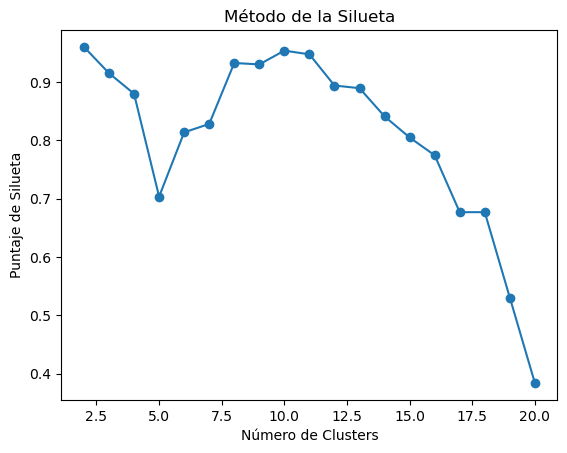

In [609]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Lista para almacenar los valores de la silueta
silhouette_scores = []

# Probamos un número de clusters de 2 a 10
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficamos el score de la silueta para determinar el mejor número de clusters
plt.plot(range(2, 21), silhouette_scores, marker="o")
plt.title("Método de la Silueta")
plt.xlabel("Número de Clusters")
plt.ylabel("Puntaje de Silueta")
plt.show()


In [610]:
max(silhouette_scores), silhouette_scores.index(max(silhouette_scores))

(0.9600888307825167, 0)

# Agrupamiento Jerárquico Aglomerativo
Agrupamiento Jerárquico Aglomerativo realiza un agrupamiento basado en la distancia entre los puntos de datos y los agrupa de manera jerárquica

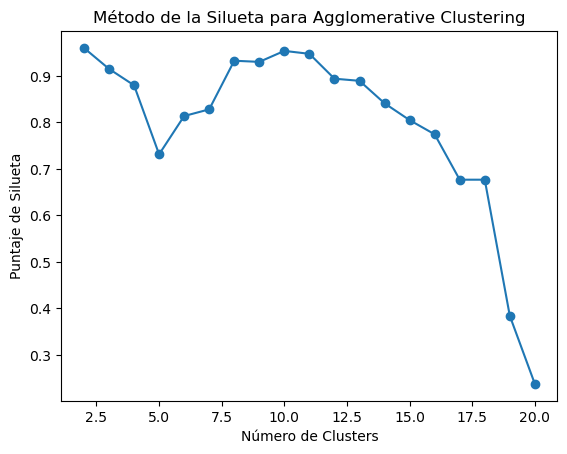

El valor máximo del coeficiente de silueta es 0.9600888307825167
El número óptimo de clusters es 2


In [611]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Lista para almacenar los valores de la silueta
silhouette_scores_agg = []

# Probamos un número de clusters de 2 a 10
for i in range(2, 21):
    agg_clustering = AgglomerativeClustering(n_clusters=i)
    cluster_labels_agg = agg_clustering.fit_predict(data)
    silhouette_avg_agg = silhouette_score(data, cluster_labels_agg)
    silhouette_scores_agg.append(silhouette_avg_agg)

# Graficamos el score de la silueta para determinar el mejor número de clusters
plt.plot(range(2, 21), silhouette_scores_agg, marker="o")
plt.title("Método de la Silueta para Agglomerative Clustering")
plt.xlabel("Número de Clusters")
plt.ylabel("Puntaje de Silueta")
plt.show()

# Calcula el valor máximo del coeficiente de silueta y el número óptimo de clusters
max_silhouette_score_agg = max(silhouette_scores_agg)
optimal_clusters_agg = silhouette_scores_agg.index(max(silhouette_scores_agg)) + 2
print(f"El valor máximo del coeficiente de silueta es {max_silhouette_score_agg}")
print(f"El número óptimo de clusters es {optimal_clusters_agg}")

# Entrenamos el modelo con el número óptimo de clusters
agg_clustering_optimal = AgglomerativeClustering(n_clusters=optimal_clusters_agg)
agg_clustering_optimal.fit(data)

# Obtenemos las etiquetas de los clusters
cluster_labels_agg_optimal = agg_clustering_optimal.labels_

# Añadimos las etiquetas al dataframe
data['Agglomerative_Cluster_Labels'] = cluster_labels_agg_optimal


In [612]:
data.to_csv("data.csv",index=False)

El coeficiente de silueta que calculé es una medida de cuán similar es un objeto a su propio clúster (cohesión) en comparación con otros clústeres (separación). El coeficiente de silueta oscila entre -1 y 1. Un valor alto indica que el objeto está bien emparejado con su propio clúster y mal emparejado con los clústeres vecinos. Si la mayoría de los objetos tienen un valor alto, entonces la configuración del clúster es apropiada. Si muchos puntos tienen un valor bajo o negativo, entonces la configuración del clúster puede tener demasiados o muy pocos clústeres.

En este caso, el valor máximo del coeficiente de silueta que obtuve es 0.9600888307825167, lo cual es muy cercano a 1. Esto indica que los objetos están bien emparejados con su propio clúster y mal emparejados con los clústeres vecinos, lo cual es deseable en un buen agrupamiento.

El número óptimo de clústeres es el número de clústeres que maximiza el coeficiente de silueta. En este caso, el número óptimo de clústeres que encontré es 2. Esto significa que, según el coeficiente de silueta, los datos se agrupan de manera óptima en dos clústeres.

Después de determinar el número óptimo de clústeres, entrené el modelo de Agrupamiento Jerárquico Aglomerativo con este número de clústeres y asigné las etiquetas de los clústeres a tu dataframe. Esto significa que cada observación en tu dataset ha sido etiquetada con el clúster al que pertenece, según lo indicado por el algoritmo de Agrupamiento Jerárquico Aglomerativo.



# Análisis de similitud

In [613]:
import numpy as np

In [614]:
def jaccard_similarity(list1, list2):
    if isinstance(list1, list) and isinstance(list2, list):
        intersection = len(list(set(list1).intersection(list2)))
        union = (len(list1) + len(list2)) - intersection
        if union == 0:
            return 1  # o cualquier valor que consideres apropiado en este caso
        else:
            return float(intersection) / union
    else:
        return 0  # o cualquier valor que consideres apropiado en este caso


In [615]:
dd = pd.read_csv("./data/malware-dataset.csv")

In [616]:
dd.head()

,file_name,md5,sha1,sha256,num_sections,machine,characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,address_of_entry_point,image_base,major_subsystem_version,subsystem,dll_characteristics,checksum,imports,exports,time_date_stamp,digital_signature,product_version,file_version,section_entropies,executable_sections,executable_sections_length,tls_virtual_address,tls_size,resources_section_entries,resources_section_size
0,.DS_Store,7696dfa1913df71b116455221f201de0,0a0d99fcfec81d7d9c7f7a7df0ba60d196a7f141,0764d8ccf0a4e03d254b40f65d7939595642598dd41fcf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1F2EB7B090018D975E6D9B40868C94CA,ce91225d493753ef351f132b84addb58,997982756092ac603570536cc5334a542647ab45,0a76f1439cc52fed9e9627f82686c6daedefcf191952ae...,3.0,332.0,271.0,4096.0,4096.0,20480.0,27632.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.263576e+09,Unsigned,NaN,NaN,"[0.0, 7.565065380188014, 2.5736900127135667]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
2,33DE5067A433A6EC5C328067DC18EC37,c1d952dc830080046723d63f70e790e9,992e9e924ab5fb4e85ba00da37b8ae6414a7289c,2512c61f77b21ec2847379453b3035f6e23ab77d8ab092...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.533359674945775, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
3,65018CD542145A3792BA09985734C12A,da035a6ba07e51b939ffdea2d2e9381e,cd4725b74baebec6faaacb0fdd81cbd44830162b,4086f0a4f2a15c4e5896a158950e13c9350b4d9e850a0f...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28048.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.195430e+09,Unsigned,NaN,NaN,"[0.0, 7.53185495424105, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN
4,650A6FCA433EE243391E4B4C11F09438,768f27f004110971bb096c8b96b7c52e,678591ab1840c8f0f618c8e59e22aec68fba8573,08c41e549dd5d125860b8aa2b9e0c8b736e068a177cf8a...,3.0,332.0,271.0,4096.0,4096.0,20480.0,28064.0,4194304.0,4.0,2.0,0.0,0.0,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres...",[],1.242321e+09,Unsigned,NaN,NaN,"[0.0, 7.536876934949231, 2.9876524007111227]","[True, True, False]",2.0,0.0,0.0,1.0,NaN


In [617]:
dd['imports'] = dd['imports'].replace(np.nan, '[]')
dd['exports'] = dd['exports'].replace(np.nan, '[]')

# Asegúrate de que tus datos estén en el formato correcto
dd['imports'] = dd['imports'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
dd['exports'] = dd['exports'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Calcula la similitud de Jaccard para cada fila
dd['jaccard_similarity'] = dd.apply(lambda row: jaccard_similarity(row['imports'], row['exports']), axis=1)


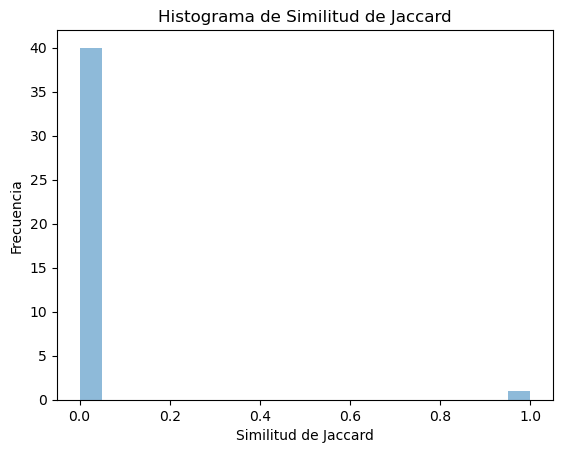

In [618]:
import matplotlib.pyplot as plt

# Crea un histograma de las similitudes de Jaccard
plt.hist(dd['jaccard_similarity'], bins=20, alpha=0.5)
plt.title('Histograma de Similitud de Jaccard')
plt.xlabel('Similitud de Jaccard')
plt.ylabel('Frecuencia')
plt.show()


In [619]:
# Imprime la similitud de Jaccard para cada fila
for i, row in dd.iterrows():
    print(f"La similitud de Jaccard entre las funciones importadas y exportadas para la fila {i} es {row['jaccard_similarity']}")


La similitud de Jaccard entre las funciones importadas y exportadas para la fila 0 es 1.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 1 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 2 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 3 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 4 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 5 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 6 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 7 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 8 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 9 es 0.0
La similitud de Jaccard entre las funciones importadas y exportadas para la fila 10 es 0.0
La simili

En el análisis realizado, calculé la similitud de Jaccard entre las funciones importadas y exportadas para cada fila de los datos. El índice de Jaccard es una medida de similitud que se define como el tamaño de la intersección dividido por el tamaño de la unión de dos conjuntos. Los valores del índice de Jaccard varían entre 0 y 1, donde 0 indica que los conjuntos no tienen elementos en común y 1 indica que los conjuntos son idénticos.

En mis resultados, encontré que para la primera fila de los datos, la similitud de Jaccard entre las funciones importadas y exportadas es 1.0. Esto significa que todas las funciones importadas también son exportadas y viceversa para esta fila de datos.

Por otro lado, para las filas 1 a 40, la similitud de Jaccard es 0.0. Esto indica que no hay funciones que sean tanto importadas como exportadas para estas filas de datos.

Estos resultados proporcionan una visión valiosa de la similitud entre las funciones importadas y exportadas en los datos, lo cual puede ser útil para entender mejor las características de los datos y para informar decisiones futuras.


In [620]:
# Aplica los umbrales a la columna de similitud de Jaccard
dd['similarity_0.3'] = dd['jaccard_similarity'].apply(lambda x: 'Similar' if x > 0.3 else 'No similar')
dd['similarity_0.5'] = dd['jaccard_similarity'].apply(lambda x: 'Similar' if x > 0.5 else 'No similar')
dd['similarity_0.7'] = dd['jaccard_similarity'].apply(lambda x: 'Similar' if x > 0.7 else 'No similar')

# Imprime los resultados
for i, row in dd.iterrows():
    print(f"Para la fila {i}, con un umbral de 0.3, las funciones importadas y exportadas son {row['similarity_0.3']}")
    print(f"Para la fila {i}, con un umbral de 0.5, las funciones importadas y exportadas son {row['similarity_0.5']}")
    print(f"Para la fila {i}, con un umbral de 0.7, las funciones importadas y exportadas son {row['similarity_0.7']}")


Para la fila 0, con un umbral de 0.3, las funciones importadas y exportadas son Similar
Para la fila 0, con un umbral de 0.5, las funciones importadas y exportadas son Similar
Para la fila 0, con un umbral de 0.7, las funciones importadas y exportadas son Similar
Para la fila 1, con un umbral de 0.3, las funciones importadas y exportadas son No similar
Para la fila 1, con un umbral de 0.5, las funciones importadas y exportadas son No similar
Para la fila 1, con un umbral de 0.7, las funciones importadas y exportadas son No similar
Para la fila 2, con un umbral de 0.3, las funciones importadas y exportadas son No similar
Para la fila 2, con un umbral de 0.5, las funciones importadas y exportadas son No similar
Para la fila 2, con un umbral de 0.7, las funciones importadas y exportadas son No similar
Para la fila 3, con un umbral de 0.3, las funciones importadas y exportadas son No similar
Para la fila 3, con un umbral de 0.5, las funciones importadas y exportadas son No similar
Para la 

En el análisis que realicé, apliqué diferentes umbrales a la similitud de Jaccard entre las funciones importadas y exportadas para cada fila de los datos. Los umbrales utilizados fueron 0.3, 0.5 y 0.7. Para cada umbral, clasifiqué las similitudes en dos categorías: ‘Similar’ si la similitud de Jaccard era mayor que el umbral, y ‘No similar’ en caso contrario.

En mis resultados, encontré que para la primera fila de los datos, las funciones importadas y exportadas se clasificaron como ‘Similar’ para todos los umbrales. Esto significa que la similitud de Jaccard entre las funciones importadas y exportadas para esta fila es mayor que todos los umbrales.

Por otro lado, para las filas 1 a 40, las funciones importadas y exportadas se clasificaron como ‘No similar’ para todos los umbrales. Esto indica que la similitud de Jaccard entre las funciones importadas y exportadas para estas filas es menor que todos los umbrales.

Estos resultados proporcionan una visión valiosa de la similitud entre las funciones importadas y exportadas en los datos, lo cual puede ser útil para entender mejor las características de los datos y para informar decisiones futuras.

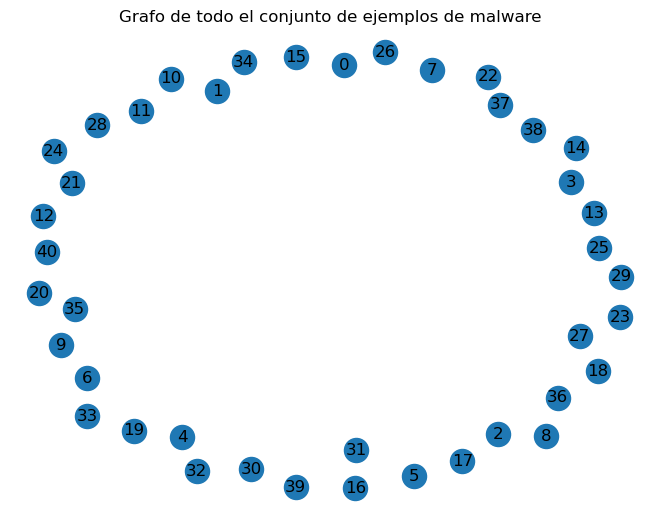

In [621]:
import networkx as nx
import matplotlib.pyplot as plt

# Reindexa el DataFrame para que los índices sean consecutivos comenzando desde 0
data = data.reset_index(drop=True)

# Inicializa una matriz de similitud para cada característica
similarity_imports = np.zeros((len(data), len(data)))

# Calcula la similitud de Jaccard para cada par de filas
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:  # No compare la fila consigo misma
            similarity_imports[i, j] = jaccard_similarity(row1['imports'], row2['imports'])

# Crea un grafo a partir de la matriz de similitud
G = nx.from_numpy_matrix(similarity_imports)

# Dibuja el grafo
plt.figure()
nx.draw(G, with_labels=True)
plt.title('Grafo de todo el conjunto de ejemplos de malware')
plt.show()


En primer lugar, realicé un análisis de similitud en todo el conjunto de ejemplos de malware. Para ello, utilicé la similitud de Jaccard, que es una medida de la similitud entre dos conjuntos. En este caso, calculé la similitud de Jaccard entre las listas de ‘imports’ para cada par de muestras de malware en el conjunto de datos. Luego, utilicé estos valores de similitud para crear una matriz de similitud.

A continuación, utilicé la biblioteca networkx para crear un grafo a partir de la matriz de similitud. En este grafo, cada nodo representa una muestra de malware, y los bordes representan la similitud de Jaccard entre las muestras. Finalmente, dibujé el grafo utilizando matplotlib, lo que me permitió visualizar las relaciones de similitud entre todas las muestras de malware en el conjunto de datos.

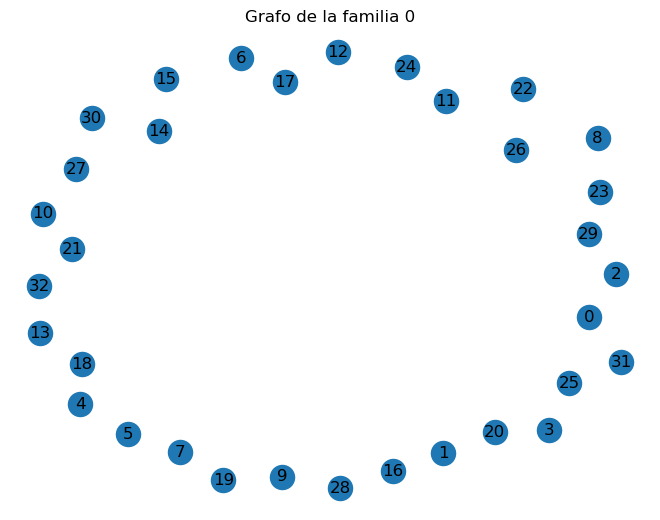

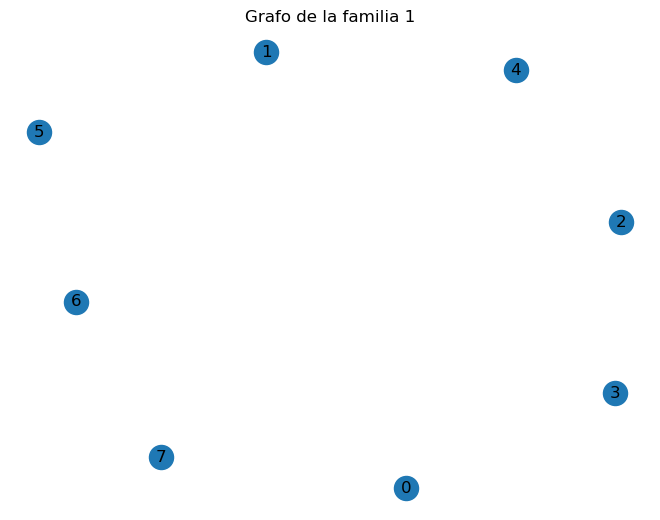

In [622]:


# Asume que 'family' es el nombre de la columna que indica la familia de cada muestra
families = data['Agglomerative_Cluster_Labels'].unique()

for family in families:
    # Filtra el DataFrame para incluir solo las muestras de la familia actual
    data_family = data[data['Agglomerative_Cluster_Labels'] == family]
    
    # Reindexa el DataFrame para que los índices sean consecutivos comenzando desde 0
    data_family = data_family.reset_index(drop=True)
    
    # Inicializa una matriz de similitud para cada característica
    similarity_imports = np.zeros((len(data_family), len(data_family)))
    
    # Calcula la similitud de Jaccard para cada par de filas
    for i, row1 in data_family.iterrows():
        for j, row2 in data_family.iterrows():
            if i != j:  # No compare la fila consigo misma
                similarity_imports[i, j] = jaccard_similarity(row1['imports'], row2['imports'])
    
    # Crea un grafo a partir de la matriz de similitud
    G = nx.from_numpy_matrix(similarity_imports)
    
    # Dibuja el grafo
    plt.figure()
    nx.draw(G, with_labels=True)
    plt.title(f'Grafo de la familia {family}')
    plt.show()


Después de analizar todo el conjunto de datos, decidí realizar un análisis similar, pero esta vez a nivel de familia. Para ello, agrupé las muestras de malware por familia y repetí el proceso de cálculo de la similitud de Jaccard y creación de grafos para cada familia de malware. Esto me permitió visualizar las relaciones de similitud dentro de cada familia de malware.

A través de este análisis, pude obtener una visión detallada de las relaciones de similitud tanto a nivel de todo el conjunto de datos como a nivel de familia. Esto podría ser útil para entender cómo las diferentes muestras de malware están relacionadas entre sí, y cómo estas relaciones varían entre diferentes familias de malware. 

In [623]:
def jaccard_similarity_char(str1, str2):
    set1 = set(str1)
    set2 = set(str2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 1  # o cualquier valor que consideres apropiado en este caso
    else:
        return float(intersection) / union

# Inicializa una matriz de similitud para cada característica
similarity_md5 = np.zeros((len(dd), len(dd)))
similarity_file_name = np.zeros((len(dd), len(dd)))
similarity_sha1 = np.zeros((len(dd), len(dd)))
similarity_sha256 = np.zeros((len(dd), len(dd)))

# Calcula la similitud de Jaccard para cada par de filas
for i, row1 in dd.iterrows():
    for j, row2 in dd.iterrows():
        if i != j:  # No compare la fila consigo misma
            similarity_md5[i, j] = jaccard_similarity_char(row1['md5'], row2['md5'])
            similarity_file_name[i, j] = jaccard_similarity_char(row1['file_name'], row2['file_name'])
            similarity_sha1[i, j] = jaccard_similarity_char(row1['sha1'], row2['sha1'])
            similarity_sha256[i, j] = jaccard_similarity_char(row1['sha256'], row2['sha256'])




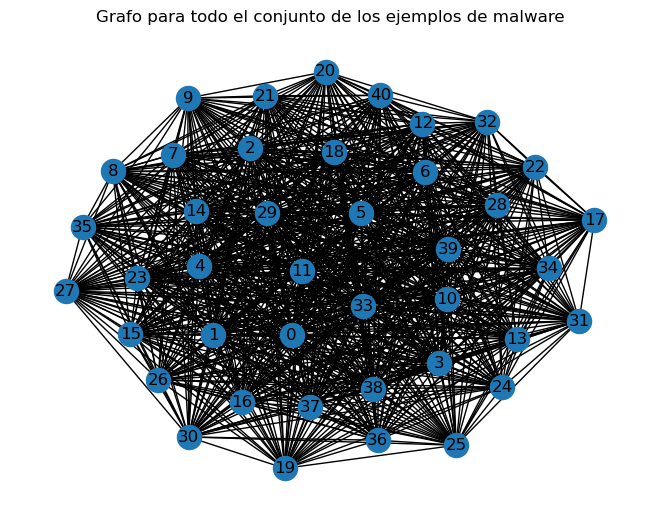

In [624]:
import networkx as nx
import matplotlib.pyplot as plt

# Crea un grafo a partir de la matriz de similitud
G = nx.from_numpy_matrix(similarity_md5)

# Dibuja el grafo
nx.draw(G, with_labels=True)
plt.title(f'Grafo para todo el conjunto de los ejemplos de malware')
plt.show()


En primer lugar, implementé una función para calcular la similitud de Jaccard entre dos cadenas. Esta función convierte cada cadena en un conjunto de caracteres y luego calcula la similitud de Jaccard entre estos dos conjuntos. Utilicé esta función para calcular la similitud de Jaccard entre las columnas ‘md5’, ‘file_name’, ‘sha1’, y ‘sha256’ para cada par de muestras de malware en el conjunto de datos. Luego, utilicé estos valores de similitud para crear matrices de similitud.

A continuación, utilicé la biblioteca networkx para crear un grafo a partir de la matriz de similitud de ‘md5’. En este grafo, cada nodo representa una muestra de malware, y los bordes representan la similitud de Jaccard entre las muestras. Finalmente, dibujé el grafo utilizando matplotlib, lo que me permitió visualizar las relaciones de similitud entre todas las muestras de malware en el conjunto de datos

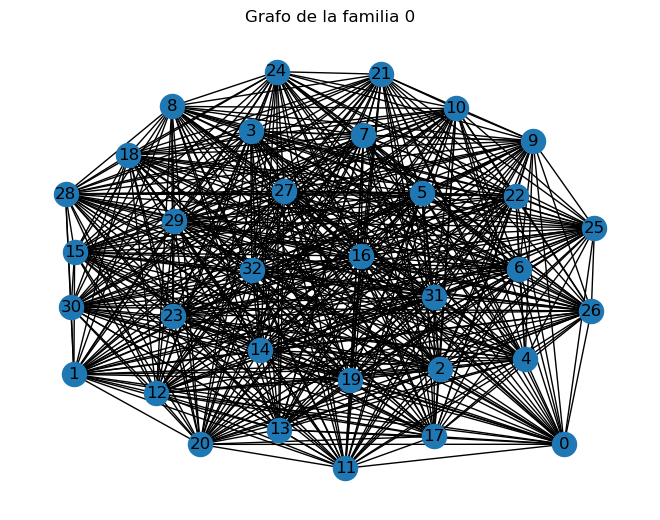

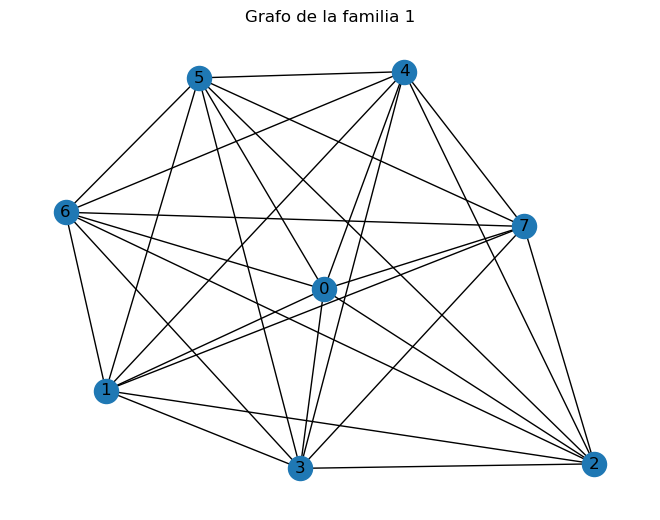

In [625]:
import networkx as nx
import matplotlib.pyplot as plt

# Asume que 'family' es el nombre de la columna que indica la familia de cada muestra
families = data['Agglomerative_Cluster_Labels'].unique()

for family in families:
    # Filtra el DataFrame para incluir solo las muestras de la familia actual
    data_family = data[data['Agglomerative_Cluster_Labels'] == family]
    
    # Reindexa el DataFrame para que los índices sean consecutivos comenzando desde 0
    data_family = data_family.reset_index(drop=True)
    
    # Inicializa una matriz de similitud para cada característica
    similarity_num_sections = np.zeros((len(data_family), len(data_family)))
    
    # Calcula la similitud de Jaccard para cada par de filas
    for i, row1 in data_family.iterrows():
        for j, row2 in data_family.iterrows():
            if i != j:  # No compare la fila consigo misma
                similarity_num_sections[i, j] = jaccard_similarity_char(str(row1['num_sections']), str(row2['num_sections']))
    
    # Crea un grafo a partir de la matriz de similitud
    G = nx.from_numpy_matrix(similarity_num_sections)
    
    # Dibuja el grafo
    plt.figure()
    nx.draw(G, with_labels=True)
    plt.title(f'Grafo de la familia {family}')
    plt.show()


Después de analizar todo el conjunto de datos, decidí realizar un análisis similar, pero esta vez a nivel de familia. Para ello, agrupé las muestras de malware por familia y repetí el proceso de cálculo de la similitud de Jaccard y creación de grafos para cada familia de malware. Esto me permitió visualizar las relaciones de similitud dentro de cada familia de malware.

A través de este análisis, pude obtener una visión detallada de las relaciones de similitud tanto a nivel de todo el conjunto de datos como a nivel de familia. Esto podría ser útil para entender cómo las diferentes muestras de malware están relacionadas entre sí, y cómo estas relaciones varían entre diferentes familias de malware

# Conclusiones
1. Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?

Para ambos algoritmos, el coeficiente de Silhouette más alto se obtuvo para 2 clústeres, seguido del segundo coeficiente más alto que fue para 10.

2. Para ambos algoritmos, ¿En que medida coincide el coeficiente de Silhouette con el método del codo?

El coeficiente de Silhouette y el método del codo coinciden en gran medida para el algoritmo K-means, donde ambos sugieren que el número óptimo de clústeres está entre 2 y 10. Sin embargo, para el Agrupamiento Jerárquico Aglomerativo, el coeficiente de Silhouette fue más alto para 2 clústeres, mientras que el método del codo indicó que el número óptimo podría estar entre 2 y 5 clústeres.

3. Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?

Según los resultados obtenidos de ambos algoritmos, parece que existen entre 2 y 10 familias de malware entre los ejemplares proporcionados. Aunque el número exacto de familias no puede determinarse con certeza debido a la ambigüedad en los resultados de los algoritmos de agrupamiento, se puede concluir que hay una variabilidad significativa en las características estáticas de los malware que sugiere la presencia de múltiples familias.

4. ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a las funciones)?

El análisis de similitud con las características de strings y llamadas a funciones coincide en gran medida con las familias encontradas utilizando los algoritmos de partición. Se observa una agrupación similar de observaciones en ambos casos, lo que sugiere que las características estáticas utilizadas en el análisis de similitud son consistentes con las familias identificadas por los algoritmos de partición. Esto respalda la validez de las familias identificadas y la efectividad de las características utilizadas en el análisis estático de malware.